In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
from copy import deepcopy
import seaborn as sns
%matplotlib inline

In [14]:
df_labels = pd.read_csv('df_val_test.csv')

In [15]:
with open('./yolo_tiny_0.3/outputs.txt') as t:
    outputs_tiny = t.read().split('\n')

# Define precision functions 

In [16]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area



In [17]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [23]:
# your code goes here !!!!==!=!=!=!=!=!=!=!=!
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=len(pred_boxes)
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=len(pred_boxes)
        fn=len(gt_boxes)
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [24]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
    
    pred_boxes_pruned = deepcopy(pred_bb)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        
        # On first iteration, define img_results for the first time:
        #print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:

            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
         #### indent for very good scores  
        pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
        pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
        # Recalculate image results for this image

        img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)
        ######
    # calculate precision and recall
    #print(img_results)
    prec, rec = calc_precision_recall(img_results)
    precisions.append(prec)

    recalls.append(rec)
    model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            print(recalls,"Recall")
            print(      recall_level,"Recall Level")
            print(       args, "Args")
            print(       prec, "precision")
        except ValueError:            
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

# Get Detectron and Hybrid Outputs

In [25]:
def float_boxes(box):
    return [round(float(x)) for x in box.split(',') if x!='']

def get_pred_det_dfs(output_det, hybrid=False):
    ls = []
    times = []
    for key in output_det.keys():
        if hybrid:
            s, time = output_det[key]
            times.append(time)
        else:
            s = output_det[key]
        
        if s=='':
            ls.append([key, *[None, None, None, None, None]])
            continue
        n_preds = int(s.split(', image_h')[0].split('=')[-1])
        boxes = s.split('Boxes(tensor([')[-1].split('))')[0].replace('[', '').replace(']', '').replace(' ', '').split('\n')
        #preds = get_boxes(boxes, n_preds)
        scores_ = s.split('scores: tensor([')[-1].split(']), pred_classes: ')[0].split(', ')

        if scores_!=['']:
            scores = (float(scores_) if type(scores_) != list else [float(x) for x in scores_])

        if n_preds>0:
            if n_preds==1:
                ls.append([key, *float_boxes(boxes[0]), scores[0]])
            else:
                for box, score in zip(boxes, scores_):
                    ls.append([key, *float_boxes(box), score])
        else:
            ls.append([key, *[None, None, None, None, None]])
    df_preds = pd.DataFrame(ls, columns=['file_name', 'xmin', 'ymin', 'xmax', 'ymax', 'score'])

    if hybrid:
        return df_preds, times 
    else:
         return  df_preds

In [26]:
def get_gt_pred_boxes(df_preds):
    gt_boxes, pred_boxes = {}, {}
    for fname in df_preds.file_name.unique():
        df_l = df_labels.query(f"file_name=='{fname}'")
        boxes = []
        for ii, n in df_l.iterrows():
            if n.isnull().values.any():
                boxes.append([0,0,0,0])
            else:
                boxes.append([n.x_min, n.y_min, n.x_max, n.y_max])
        gt_boxes[fname] = boxes

        df_p = df_preds.query(f"file_name=='{fname}'")    
        p_boxes, scores = [], []
        pred_boxes[fname] = {}

        for ii, m in df_p.iterrows():
            if m.isnull().values.any():
                p_boxes.append([0,0,0,0])
                scores.append(0)
            else:
                p_boxes.append([m.xmin, m.ymin, m.xmax, m.ymax])
                scores.append(float(m.score))
        pred_boxes[fname]['boxes'] = p_boxes
        pred_boxes[fname]['scores'] = scores

    return gt_boxes, pred_boxes

In [27]:
# Detectron2 only
with open("detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds = get_pred_det_dfs(output_det)

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds)

get_avg_precision_at_iou(gt_boxes, pred_boxes)

[0.04273504] Recall
0.0 Recall Level
[0] Args
0.7142857142857143 precision


{'avg_prec': 0.06493506493506494,
 'precisions': array([0.71428571]),
 'recalls': array([0.04273504]),
 'model_thrs': [0.9976]}

In [28]:
# Detectron2 only
with open("detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds = get_pred_det_dfs(output_det).query(f"file_name in {[n for n in df_preds.file_name if 'armas' in n]}")

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds)

get_avg_precision_at_iou(gt_boxes, pred_boxes)

[0.04065041] Recall
0.0 Recall Level
[0] Args
1.0 precision


{'avg_prec': 0.09090909090909091,
 'precisions': array([1.]),
 'recalls': array([0.04065041]),
 'model_thrs': [0.9976]}

In [29]:
# Hybrid 0.3
with open("hybrid_0.3/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times = get_pred_det_dfs(output_det, hybrid=True)

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds)

get_avg_precision_at_iou(gt_boxes, pred_boxes)


[0.01428571] Recall
0.0 Recall Level
[0] Args
1.0 precision


{'avg_prec': 0.09090909090909091,
 'precisions': array([1.]),
 'recalls': array([0.01428571]),
 'model_thrs': [0.99771]}

In [30]:
# Hybrid 0.3
with open("hybrid_0.3/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times = get_pred_det_dfs(output_det, hybrid=True)

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds.query(f"file_name in {[n for n in df_preds.file_name if 'armas' in n]}"))

get_avg_precision_at_iou(gt_boxes, pred_boxes)


[0.0141844] Recall
0.0 Recall Level
[0] Args
1.0 precision


{'avg_prec': 0.09090909090909091,
 'precisions': array([1.]),
 'recalls': array([0.0141844]),
 'model_thrs': [0.99771]}

In [107]:
np.mean(times2)

0.048810143440295335

In [48]:
# Hybrid 0.2
with open("hybrid_0.2/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times = get_pred_det_dfs(output_det, hybrid=True)

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds)

get_avg_precision_at_iou(gt_boxes, pred_boxes)


[0.01351351] Recall
0.0 Recall Level
[0] Args
1.0 precision


{'avg_prec': 0.09090909090909091,
 'precisions': array([1.]),
 'recalls': array([0.01351351]),
 'model_thrs': [0.99771]}

In [466]:
print(np.array(times).mean())

0.08435928026835124


In [49]:
# Hybrid 0.1
with open("hybrid_0.1/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times = get_pred_det_dfs(output_det, hybrid=True)

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds)

get_avg_precision_at_iou(gt_boxes, pred_boxes)


[0.01298701] Recall
0.0 Recall Level
[0] Args
0.6666666666666666 precision


{'avg_prec': 0.0606060606060606,
 'precisions': array([0.66666667]),
 'recalls': array([0.01298701]),
 'model_thrs': [0.99771]}

In [99]:
# Hybrid 0.1

with open("hybrid_0.1/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times = get_pred_det_dfs(output_det, hybrid=True)

gt_boxes, pred_boxes = get_gt_pred_boxes(df_preds.query(f"file_name in {[n for n in df_preds.file_name if 'armas' in n]}"))

get_avg_precision_at_iou(gt_boxes, pred_boxes)


[0.01290323] Recall
0.0 Recall Level
[0] Args
1.0 precision


{'avg_prec': 0.09090909090909091,
 'precisions': array([1.]),
 'recalls': array([0.01290323]),
 'model_thrs': [0.99771]}

In [ ]:
C:\Users\edvar\Documents\GitHub\video_editing_for_ML\output_hybrid_0.2

In [35]:
with open("../video_editing_for_ML/output_hybrid_0.2/times.txt",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times3 = get_pred_det_dfs(output_det, hybrid=True)

with open("hybrid_0.2/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times2 = get_pred_det_dfs(output_det, hybrid=True)

with open("hybrid_0.1/detection_out.pckl",'rb') as f:
    output_det = pickle.load(f)
    
df_preds, times1 = get_pred_det_dfs(output_det, hybrid=True)


In [46]:
timesT = [float(x) for x in list(df_pred_tiny.time)]

In [55]:
with open("../video_editing_for_ML/output_hybrid_0.2/times.txt",'r') as f:
    times2 = [float(x) for x in f.read().split('\n')]

with open("../video_editing_for_ML/output_hybrid_basic/times.txt",'r') as f:
    timesT = [float(x) for x in f.read().split('\n')]
    

In [57]:
sum(times2), sum(timesT)

(30.555149793624878, 25.51137137413025)

In [74]:
ls = []
for m, t in zip(['detectron2', 'hybrid', 'yolo'], [123.3, 30.6, 11.3]):
    ls.append([m, t])
df_times = pd.DataFrame(ls, columns=['Model', 'Time (s)'])

In [75]:
import seaborn as sn

In [104]:
ax.?

Text(0.5, 1.0, 'Example Video Processing Time')

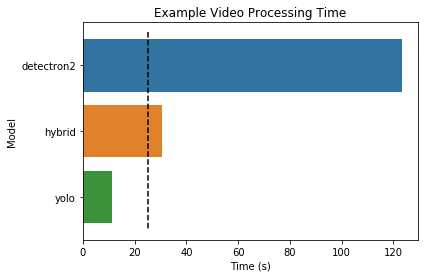

In [105]:
fig, ax = plt.subplots(1, 1)
sn.barplot(x='Time (s)', y='Model', data=df_times, ax=ax)
ax.vlines(25, ymin=-.5, ymax=2.5, linestyle='--')
ax.set_title('Example Video Processing Time')

In [98]:
ax.vlines?

In [63]:
(len(times2)*18)/1000

11.268

In [104]:
gt_boxes, pred_boxes = get_gt_pred_boxes(df_pred_tiny)

get_avg_precision_at_iou(gt_boxes, pred_boxes)

{'avg_prec': 0.0,
 'precisions': array([0.]),
 'recalls': array([0.]),
 'model_thrs': [0.9570940136909485]}

In [96]:
# Apply NMS
pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres,
                           multi_label=False, classes=opt.classes, agnostic=opt.agnostic_nms)

# Pass on to Detectron if Classes detected
if pred != [None]:
    im = cv2.imread(path)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=statement_metadata,
        scale=1.,
        instance_mode=ColorMode.IMAGE
    )
    instances = outputs["instances"].to("cpu")
    instances.remove('pred_masks')
    end_time = time()
    info[fname] = [str(instances), end_time-start_time]

    v = v.draw_instance_predictions(instances)
    result = v.get_image()[:, :, ::-1]
    file_name = ntpath.basename(path)
    write_res = cv2.imwrite(f'output_hybrid/{file_name}', result)
else:
    im = cv2.imread(path)
    file_name = ntpath.basename(path)

    end_time = time()
    info[fname] = ['', end_time-start_time]

    write_res = cv2.imwrite(f'output_hybrid/{file_name}', im)

,file_name,xmin,ymin,xmax,ymax,score
0,armas (1).jpg,0.0,0.0,126.0,103.0,0.99606
1,armas (1).jpg,126.0,52.0,237.0,140.0,0.99559
2,armas (1004).jpg,38.0,74.0,109.0,132.0,0.95829
3,armas (1004).jpg,37.0,70.0,175.0,274.0,0.90375
4,armas (1013).jpg,74.0,49.0,186.0,108.0,0.99068
...,...,...,...,...,...,...
337,frame23.jpg,2.0,0.0,154.0,109.0,0.98607
338,frame230.jpg,NaN,NaN,NaN,NaN,None
339,frame231.jpg,NaN,NaN,NaN,NaN,None
340,frame232.jpg,NaN,NaN,NaN,NaN,None


In [94]:
df_pred_tiny

,file_name,xmin,ymin,xmax,ymax,score
0,armas (1).jpg,4,5,128,101,0.956654
1,armas (1).jpg,121,51,240,142,0.759961
2,armas (1004).jpg,63,87,109,127,0.333220
3,armas (1013).jpg,78,48,186,133,0.835131
4,armas (1015).jpg,112,81,137,151,0.889160
...,...,...,...,...,...,...
343,frame23.jpg,0,0,0,0,0.000000
344,frame230.jpg,0,0,0,0,0.000000
345,frame231.jpg,0,0,0,0,0.000000
346,frame232.jpg,0,0,0,0,0.000000


In [95]:
df_labels

,Unnamed: 0,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,0,armas (1).jpg,240,145,3,1,128,100,pistol
1,1,armas (1).jpg,240,145,123,47,238,145,pistol
2,8,armas (1004).jpg,183,275,12,69,119,140,pistol
3,18,armas (1013).jpg,275,184,76,47,181,103,pistol
4,20,armas (1015).jpg,268,188,114,84,137,129,pistol
...,...,...,...,...,...,...,...,...,...
168,3390,armas (936).jpg,303,166,1,23,119,87,pistol
169,3391,armas (936).jpg,303,166,147,6,258,84,pistol
170,3406,armas (95).jpg,1300,867,19,191,594,503,pistol
171,3421,armas (963).jpg,272,185,99,38,238,107,pistol


In [442]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [205]:
df_p.isnull().sum().sum()

5

In [255]:
get_avg_precision_at_iou(gt_boxes, pred_boxes)

Mode score :  0
frame233.jpg


AttributeError: 'float' object has no attribute 'append'

In [251]:
gt_boxes

{'armas (2062).jpg': [[44.0, 79.0, 757.0, 627.0]],
 'armas (2489).jpg': [[1.0, 1.0, 157.0, 116.0]],
 'armas (2961).jpg': [[35.0, 10.0, 824.0, 613.0]],
 'armas (845).jpg': [[32.0, 28.0, 171.0, 149.0]],
 'armas (280).jpg': [[173.0, 172.0, 205.0, 342.0]],
 'armas (991).jpg': [[75.0, 77.0, 141.0, 163.0]],
 'armas (2716).jpg': [[5.0, 4.0, 152.0, 110.0]],
 'armas (1971).jpg': [[315.0, 163.0, 388.0, 226.0]],
 'armas (1691).jpg': [[211.0, 158.0, 261.0, 211.0]],
 'armas (136).jpg': [[47.0, 30.0, 348.0, 196.0]],
 'armas (622).jpg': [[108.0, 31.0, 549.0, 463.0]],
 'armas (1792).jpg': [[80.0, 121.0, 1315.0, 1001.0]],
 'armas (308).jpg': [[408.0, 722.0, 573.0, 960.0],
  [901.0, 757.0, 1030.0, 960.0]],
 'armas (2213).jpg': [[4.0, 4.0, 156.0, 117.0]],
 'armas (526).jpg': [[49.0, 21.0, 185.0, 137.0]],
 'armas (2445).jpg': [[4.0, 1.0, 157.0, 117.0]],
 'armas (2288).jpg': [[2.0, 3.0, 156.0, 115.0]],
 'armas (321).jpg': [[474.0, 617.0, 779.0, 1002.0]],
 'armas (2788).jpg': [[169.0, 275.0, 275.0, 333.0]],

In [127]:
df_labels = pd.read_csv('test_set.csv')

In [221]:
pred_boxes

{'armas (2062).jpg': {'boxes': [[49.0, 621.0, 746.0, 52.0]],
  'scores': [0.9966]},
 'armas (2489).jpg': {'boxes': [[4.0, 117.0, 151.0, 0.0]], 'scores': [0.9968]},
 'armas (2961).jpg': {'boxes': [[106.0, 592.0, 857.0, 0.0]],
  'scores': [0.9187]},
 'armas (845).jpg': {'boxes': [[35.0, 150.0, 173.0, 29.0]],
  'scores': [0.9952]},
 'armas (280).jpg': {'boxes': [[172.0, 338.0, 202.0, 166.0],
   [155.0, 354.0, 230.0, 163.0]],
  'scores': ['0.9330', '0.8642']},
 'armas (991).jpg': {'boxes': [[76.0, 173.0, 141.0, 65.0]],
  'scores': [0.9772]},
 'armas (2716).jpg': {'boxes': [[6.0, 113.0, 146.0, 0.0]], 'scores': [0.9946]},
 'armas (1971).jpg': {'boxes': [[310.0, 229.0, 395.0, 166.0]],
  'scores': [0.9346]},
 'armas (1691).jpg': {'boxes': [[210.0, 206.0, 262.0, 157.0]],
  'scores': [0.9948]},
 'armas (136).jpg': {'boxes': [[85.0, 206.0, 341.0, 25.0]],
  'scores': [0.9944]},
 'armas (622).jpg': {'boxes': [[98.0, 463.0, 542.0, 25.0]],
  'scores': [0.9967]},
 'armas (1792).jpg': {'boxes': [[74.0,

In [173]:
file_name in df_det.dropna().file_name.unique()

False

In [37]:
def get_preds(output_line):
    fname, s = output_line.split(': ')
    s = s.replace('tensor(', '').replace('["', '').replace('.)', '').replace('],', '').replace("']", '').replace('s ', ' ').replace('x', ' ').replace(',', '').replace("device=\'cuda:0\')", '').replace("[", '').replace('"]', '').replace('. ', '').replace('s', '')
    return [fname]+s.split()

In [38]:
def get_df_tiny(outputs):
    df = pd.DataFrame()
    columns = ["file_name", "xmin", "ymin", "xmax", "ymax", "score"]

    rows = []
    
    for pred in outputs:
        row = get_preds(pred)[:6]

        if 'N/A' in row:
            rows.append([row[0], float('Nan'), float('Nan'), float('Nan'), float('Nan'), float('NaN')])
        else:        
            rows.append([row[0], int(row[1]), int(row[2]), int(row[3]), int(row[4]), float(row[5])])    
    return pd.DataFrame(rows, columns=columns)

df_pred_tiny = get_df_tiny(outputs_tiny)

#xmax, ymax = [], []
##for ii, m in df_pred_tiny.iterrows():
 #   if m.xmin!=None:
 #       xmax.append(int(int(m.xmin)+int(m.xwidth)))
 #       ymax.append(int(int(m.ymin)+int(m.yheight)))
 #   else:
 #       xmax.append(0)
 #       ymax.append(0)
#df_pred_tiny["xmax"]=xmax
#df_pred_tiny["ymax"]=ymax


In [40]:
df_pred_tiny

,file_name,xmin,ymin,xmax,ymax,score
0,armas (1).jpg,4.0,5.0,128.0,101.0,0.956654
1,armas (1).jpg,121.0,51.0,240.0,142.0,0.759961
2,armas (1004).jpg,63.0,87.0,109.0,127.0,0.333220
3,armas (1013).jpg,78.0,48.0,186.0,133.0,0.835131
4,armas (1015).jpg,112.0,81.0,137.0,151.0,0.889160
...,...,...,...,...,...,...
343,frame23.jpg,NaN,NaN,NaN,NaN,NaN
344,frame230.jpg,NaN,NaN,NaN,NaN,NaN
345,frame231.jpg,NaN,NaN,NaN,NaN,NaN
346,frame232.jpg,NaN,NaN,NaN,NaN,NaN


In [85]:
gt_boxes, pred_boxes = get_gt_pred_boxes(df_pred_tiny)

get_avg_precision_at_iou(gt_boxes, pred_boxes)

{'avg_prec': 0.0,
 'precisions': array([0.]),
 'recalls': array([0.]),
 'model_thrs': [0.9570940136909485]}

In [77]:
df_pred_tiny

,file_name,xmin,ymin,xwidth,yheight,score,xmax,ymax
0,armas (1).jpg,4,5,128,101,0.9566540122032166,132,106
1,armas (1).jpg,121,51,240,142,0.7599612474441528,361,193
2,armas (1004).jpg,63,87,109,127,0.3332202136516571,172,214
3,armas (1013).jpg,78,48,186,133,0.8351311087608337,264,181
4,armas (1015).jpg,112,81,137,151,0.8891599774360657,249,232
...,...,...,...,...,...,...,...,...
343,frame23.jpg,0,0,0,0,0,0,0
344,frame230.jpg,0,0,0,0,0,0,0
345,frame231.jpg,0,0,0,0,0,0,0
346,frame232.jpg,0,0,0,0,0,0,0


In [41]:
def get_dfs(outputs):
    df = pd.DataFrame()
    columns = ["file_name", "xmin", "ymin", "xwidth", "yheight", "pred_conf", "cls", "time", "height", "width"]

    rows = []
    
    for pred in outputs:
        row = get_preds(pred)

        if 'N/A' in row:
            rows.append([row[0], None, None, None, None, None, None, row[-1], None, None])
        else:        
            rows.append(row)    
    return pd.DataFrame(rows, columns=columns)

df_pred_tiny = get_dfs(outputs_tiny)

xmax, ymax = [], []
for ii, m in df_pred_tiny.iterrows():
    if m.xmin!=None:
        xmax.append(int(int(m.xmin)+int(m.xwidth)))
        ymax.append(int(int(m.ymin)+int(m.yheight)))
    else:
        xmax.append("None")
        ymax.append("None")
df_pred_tiny["xmax"]=xmax
df_pred_tiny["ymax"]=ymax


In [42]:
df_pred_tiny

,file_name,xmin,ymin,xwidth,yheight,pred_conf,cls,time,height,width,xmax,ymax
0,armas (1).jpg,4,5,128,101,0.9566540122032166,0.0,0.022563934326171875,448,640,132,106
1,armas (1).jpg,121,51,240,142,0.7599612474441528,0.0,0.022563934326171875,448,640,361,193
2,armas (1004).jpg,63,87,109,127,0.3332202136516571,0.0,0.017884492874145508,640,448,172,214
3,armas (1013).jpg,78,48,186,133,0.8351311087608337,0.0,0.016967296600341797,448,640,264,181
4,armas (1015).jpg,112,81,137,151,0.8891599774360657,0.0,0.017887353897094727,512,640,249,232
...,...,...,...,...,...,...,...,...,...,...,...,...
343,frame23.jpg,None,None,None,None,None,None,0.012243986129760742,None,None,None,None
344,frame230.jpg,None,None,None,None,None,None,0.012328624725341797,None,None,None,None
345,frame231.jpg,None,None,None,None,None,None,0.012336254119873047,None,None,None,None
346,frame232.jpg,None,None,None,None,None,None,0.012249946594238281,None,None,None,None


In [250]:
times = []
for f in df_pred_tiny.file_name.unique():
    
    df_ = df_pred_tiny.query(f"file_name=='{f}'")
    times.append(float(df_.time.values[0]))

In [159]:
len(df_pred.file_name.unique()), len(df_labels.file_name.unique())

(300, 150)

In [252]:
np.array(times).mean()

0.01722306728363037

In [307]:
bb_intersection_over_union([int(p.xmin), int(p.ymin), int(p.xwidth), int(p.yheight)], [l.xmin, l.ymin, l.xmax, l.ymax])

0.6305760069294066

In [305]:
[int(p.xmin), int(p.ymin), int(p.xwidth), int(p.yheight)]

[78, 48, 186, 133]

In [306]:
[l.xmin, l.ymin, l.xmax, l.ymax  ]

[76, 47, 181, 103]

In [388]:

res = []
for file_name in df_pred.file_name.unique():
    df_p = df_pred.query(f"file_name=='{file_name}'")
    df_l = df_labels.query(f"file_name=='{file_name}'")
    
    if len(df_p)>0 and len(df_l)==0:
        for x in range(len(df_p)):
            res.append('FP')

    if len(df_p)==0 and len(df_l)!=0:
        for x in range(len(df_l)):
            res.append('FN')
        
    if df_p.xmin.values[0]!=None:
        for i, p in df_p.iterrows():
            for j, l in df_l.iterrows():
                iou = bb_intersection_over_union([int(p.xmin), int(p.ymin), int(p.xwidth), int(p.yheight)], [l.xmin, l.ymin, l.xmax, l.ymax])
                if iou>=0.5:
                    res.append('TP')
                else:
                    res.append('FP')

        

In [389]:
len(res)

379

In [369]:
len(df_pred_tiny)

348

In [390]:

res = []
for file_name in df_pred.file_name.unique():
    df_p = df_pred.query(f"file_name=='{file_name}'")
    df_l = df_labels.query(f"file_name=='{file_name}'")
    
    if len(df_p)>0 and len(df_l)==0:
        for x in range(len(df_p)):
            res.append('FP')

    if df_p.xmin.values[0]==None and len(df_l)!=0:
        #for x in range(len(df_l)):
        res.append('FN')
        
    if df_p.xmin.values[0]!=None and len(df_l)!=0:
        for i, p in df_p.iterrows():
            for j, l in df_l.iterrows():
                iou = bb_intersection_over_union([int(p.xmin), int(p.ymin), int(p.xwidth), int(p.yheight)], [l.xmin, l.ymin, l.xmax, l.ymax])
                if iou>0.5:
                    res.append('TP')
                else:
                    res.append('FP')

        

In [391]:
from collections import Counter

In [392]:
cTP = Counter(res)['TP']
cFP = Counter(res)['FP']
cFN = Counter(res)['FN']

In [393]:
cTP/(cTP+cFP), cTP/(cTP+cFN)

(0.39050131926121373, 0.8654970760233918)

In [287]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    #assert bb1['x1'] < bb1['x2']
    #assert bb1['y1'] < bb1['y2']
    #assert bb2['x1'] < bb2['x2']
    #assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']+1) * (bb1['y2'] - bb1['y1']+1)
    bb2_area = (bb2['x2'] - bb2['x1']+1) * (bb2['y2'] - bb2['y1']+1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [288]:
bbox1 = {'x1':int(p.xmin), 'y1':int(p.ymax), 'x2':int(p.xmax), "y2":int(p.ymin)} 
bbox2 = {"x1":l.xmin, "y1":l.ymax, "x2":l.xmax, "y2":l.ymin}

In [289]:
get_iou(bbox1, bbox2)

0.0

In [263]:
p

file_name         armas (106).jpg
xmin                         None
ymin                         None
xwidth                       None
yheight                      None
pred_conf                    None
cls                          None
time         0.030156373977661133
height                       None
width                        None
xmax                         None
Ymax                          NaN
ymax                         None
Name: 7, dtype: object

In [187]:
xmax, ymax = [], []
for ii, m in df_pred_tiny.iterrows():
    if m.xmin!=None:
        xmax.append(int(int(m.xmin)+int(m.xwidth)))
        ymax.append(int(int(m.ymin)+int(m.yheight)))
    else:
        xmax.append("None")
        ymax.append("None")
df_pred["xmax"]=xmax
df_pred["ymax"]=ymax

,file_name,xmin,ymin,xwidth,yheight,pred_conf,cls,time,height,width,xmax,Ymax,ymax
0,armas (1).jpg,4,5,128,101,0.9566540122032166,0.0,0.022563934326171875,448,640,132,106.0,106
1,armas (1).jpg,121,51,240,142,0.7599612474441528,0.0,0.022563934326171875,448,640,361,193.0,193
2,armas (1004).jpg,63,87,109,127,0.3332202136516571,0.0,0.017884492874145508,640,448,172,214.0,214
3,armas (1013).jpg,78,48,186,133,0.8351311087608337,0.0,0.016967296600341797,448,640,264,181.0,181
4,armas (1015).jpg,112,81,137,151,0.8891599774360657,0.0,0.017887353897094727,512,640,249,232.0,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,frame23.jpg,None,None,None,None,None,None,0.012243986129760742,None,None,None,NaN,None
344,frame230.jpg,None,None,None,None,None,None,0.012328624725341797,None,None,None,NaN,None
345,frame231.jpg,None,None,None,None,None,None,0.012336254119873047,None,None,None,NaN,None
346,frame232.jpg,None,None,None,None,None,None,0.012249946594238281,None,None,None,NaN,None


In [179]:
len(df_pred)

348

In [201]:
df_det

,file_name,xmin,ymin,xmax,ymax
0,armas (2062).jpg,49.0,52.0,746.0,621.0
1,armas (2489).jpg,4.0,0.0,151.0,117.0
2,armas (2961).jpg,106.0,0.0,857.0,592.0
3,armas (845).jpg,35.0,29.0,173.0,150.0
4,armas (280).jpg,NaN,NaN,NaN,NaN
...,...,...,...,...,...
295,frame23.jpg,2.0,0.0,154.0,109.0
296,frame230.jpg,NaN,NaN,NaN,NaN
297,frame231.jpg,NaN,NaN,NaN,NaN
298,frame232.jpg,NaN,NaN,NaN,NaN


In [203]:
df_det.query("file_name=='armas (2062).jpg'")

,file_name,xmin,ymin,xmax,ymax
0,armas (2062).jpg,49.0,52.0,746.0,621.0


(-0.5, 274.5, 183.5, -0.5)

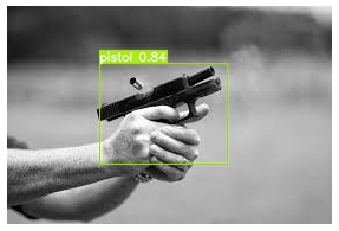

In [204]:
img = cv2.imread('./yolo_tiny_detect/armas (1013).jpg')
plt.imshow(img)
plt.axis('off')
#plt.savefig('image_bound_test1.png')


In [48]:
df_labels = pd.read_csv('df_val_test.csv')

In [50]:
df_labels.query("file_name=='armas (1004).jpg'")

,Unnamed: 0,file_name,width,height,x_min,y_min,x_max,y_max,class_name
2,8,armas (1004).jpg,183,275,12,69,119,140,pistol


In [92]:
res_df = df.query("fname=='arma (1004).jpg'")

def annotate_image(annotations, resize=True):
    file_name = annotations.file_name.to_numpy()[0]
    img = cv2.cvtColor(cv2.imread('./yolo_tiny_detect/armas (1004).jpg'), cv2.COLOR_BGR2RGB)

    for i, a in annotations.iterrows():
        cv2.rectangle(img, (a.x_min, a.y_min),
                      (a.x_max, a.y_max), (0, 255, 0), 2)
    
    for i, a in res_df.iterrows():
        cv2.rectangle(img, 
                      (int(a.xmin.replace('.', '')), int(a.ymin.replace('.', ''))),
                      ((int(a.xmin.replace('.', ''))+int(a.xwidth.replace('.', ''))),
                           (int(a.ymin.replace('.', ''))+int(a.yheight.replace('.', '')))), 
                           (0, 255, 0), 2)

    if not resize:
        return img

    return cv2.resize(img, (384, 384), interpolation=cv2.INTER_AREA)

In [93]:
img_df = df_labels.query("file_name=='armas (1004).jpg'")
img = annotate_image(img_df, resize=False)

(-0.5, 182.5, 274.5, -0.5)

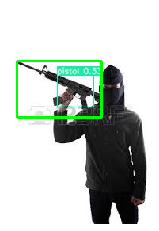

In [55]:
plt.imshow(img)
plt.axis('off')

In [73]:
int(res_df.xmin.values[0].replace('.', ''))

63

In [165]:
df_labels

,Unnamed: 0,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,0,armas (1).jpg,240,145,3,1,128,100,pistol
1,1,armas (1).jpg,240,145,123,47,238,145,pistol
2,8,armas (1004).jpg,183,275,12,69,119,140,pistol
3,18,armas (1013).jpg,275,184,76,47,181,103,pistol
4,20,armas (1015).jpg,268,188,114,84,137,129,pistol
...,...,...,...,...,...,...,...,...,...
168,3390,armas (936).jpg,303,166,1,23,119,87,pistol
169,3391,armas (936).jpg,303,166,147,6,258,84,pistol
170,3406,armas (95).jpg,1300,867,19,191,594,503,pistol
171,3421,armas (963).jpg,272,185,99,38,238,107,pistol


In [166]:
df_pred

,file_name,xmin,ymin,xwidth,yheight,pred_conf,cls,time,height,width
0,armas (1).jpg,4,5,128,101,0.9566540122032166,0.0,0.022563934326171875,448,640
1,armas (1).jpg,121,51,240,142,0.7599612474441528,0.0,0.022563934326171875,448,640
2,armas (1004).jpg,63,87,109,127,0.3332202136516571,0.0,0.017884492874145508,640,448
3,armas (1013).jpg,78,48,186,133,0.8351311087608337,0.0,0.016967296600341797,448,640
4,armas (1015).jpg,112,81,137,151,0.8891599774360657,0.0,0.017887353897094727,512,640
...,...,...,...,...,...,...,...,...,...,...
343,frame23.jpg,None,None,None,None,None,None,0.012243986129760742,None,None
344,frame230.jpg,None,None,None,None,None,None,0.012328624725341797,None,None
345,frame231.jpg,None,None,None,None,None,None,0.012336254119873047,None,None
346,frame232.jpg,None,None,None,None,None,None,0.012249946594238281,None,None


In [91]:
for i, a in res_df.iterrows():
        cv2.rectangle(img, 
                      (int(a.xmin.replace('.', '')), int(a.ymin.replace('.', ''))),
                      ((int(a.xmin.replace('.', ''))+int(a.xwidth.replace('.', ''))),
                           (int(a.ymin.replace('.', ''))+int(a.yheight.replace('.', '')))), 
                           (0, 255, 0), 2)

In [90]:

int(a.xmin.replace('.', ''))

63

In [142]:
np.array(df_pred.time)

array(['0.022563934326171875', '0.022563934326171875',
       '0.017884492874145508', '0.016967296600341797',
       '0.017887353897094727', '0.017064571380615234',
       '0.01694345474243164', '0.030156373977661133s',
       '0.11868500709533691', '0.020685672760009766',
       '0.020685672760009766', '0.020641565322875977',
       '0.025399208068847656', '0.028699159622192383',
       '0.023839473724365234', '0.023839473724365234',
       '0.024956703186035156', '0.024956703186035156',
       '0.029973745346069336', '0.029973745346069336',
       '0.029973745346069336', '0.029973745346069336',
       '0.029973745346069336', '0.021096229553222656',
       '0.02271127700805664', '0.02271127700805664', '0.0227053165435791',
       '0.0227053165435791', '0.029213428497314453',
       '0.029213428497314453', '0.03654217720031738',
       '0.03654217720031738', '0.03654217720031738',
       '0.01830744743347168', '0.015328407287597656s',
       '0.019982337951660156', '0.02004718780517578

In [154]:
np.array([float(t) for t in df_pred.time]).mean()


0.01818329095840454

In [265]:
with open('times_0.2.txt', 'r') as t:
    fr = t.read().split('\n')

In [267]:
np.array([float(t) for t in fr] ).mean()*625

30.506339650184586

In [263]:
float(fr[0])

0.43216657638549805